## Outline

Via is considering expanding its service area to include Astoria, Queens. We are trying to find the optimal way to launch this expansion.

We are using the NYC taxi data from the period before July 2016 (described and available here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml, also available either through BiqQuery https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data, or in smaller samples from http://www.andresmh.com/nyctaxitrips/), to answer the following questions:

Analysis Questions:

1. How would we assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?

2. How does this compare to our current area of service (e.g. the Upper East Side)?

3. Would we provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why?

4. Would we launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

Statistical Questions:

5. If given a metric for efficiency (assume we don't know how it's calculated), how to determine whether a specific zone is more efficient than the rest of the city? How would we determine why it’s more efficient?

6. How would we compare the distributions of intra-city trip prices between two different cities? How would we test whether any differences we find are explained by distance and duration?



  1. [Opening and Exploring the Test Data](#chapter-1)
      1. [Data Inspection](#chapter-1a)
      2. [Joining the Tables](#chapter-1b)
      3. [Distribution of the Data](#chapter-1c)
  2. [The Difference Between \$39 and \$59](#chapter-2)
      1. [Is the Difference Significant?](#chapter-2a)
  3. [Further Insights](#chapter-3)
      1. [Predicting Conversion](#chapter-3a)
  5. [Conclusions and Insights](#chapter-4)
      1. [Next Steps](#chapter-4a)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle

from sqlalchemy import create_engine
from sqlalchemy.sql import text
import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = True

## Data in 2013 August, 12,303,170 rides in total

In [3]:
disk_engine = create_engine('sqlite:///trip_data_2013.db')

In [6]:
print pd.read_sql_query('SELECT COUNT(*) FROM trip_data', disk_engine)

   COUNT(*)
0  12303170


In [4]:
zones = pd.read_csv("./taxi_zones/taxi_zone_lookup.csv")
zones.columns

Index([u'LocationID', u'Borough', u'Zone', u'service_zone'], dtype='object')

In [135]:
Manhattan_zones = zones[zones.Borough=="Manhattan"]["LocationID"].tolist()
Astoria_zones = zones[[row in ["Astoria", "Old Astoria", "Astoria Park"] 
                       for row in zones.Zone]]["LocationID"].tolist()
Laguardia_zones = zones[zones.Zone == "LaGuardia Airport"]["LocationID"].tolist()
Steinway_zones = zones[zones.Zone == "Steinway"]["LocationID"].tolist()
Upper_east_zones = zones[[row in ["Upper East Side North", "Upper East Side South"] 
                          for row in zones.Zone]]["LocationID"].tolist()
Jackson_zones = zones[zones.Zone == "Jackson Heights"]["LocationID"].tolist()
Woodside_zones = zones[zones.Zone == "Woodside"]["LocationID"].tolist()

In [136]:
def region(location_id):
    if location_id in Astoria_zones:
        return "AST"
    elif location_id in Laguardia_zones:
        return "LAG"
    elif location_id in Upper_east_zones:
        return "UES"
    elif location_id in Steinway_zones:
        return "STW"
    elif location_id in Jackson_zones:
        return "JKH"
    elif location_id in Woodside_zones:
        return "WDS"
    else:
        return

In [102]:
def borough(location_id):
    if location_id in Manhattan_zones:
        return "MAN"
    else:
        return

## Analysis questions:

**Question 1: How would you assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?**

**Question 2: How does this compare to our current area of service (e.g. the Upper East Side)?**

### Exploratory Analysis

In [8]:
def query_regional_rides(region_zones):
    # aggregating the rides within the specified region, 
    #                       between this region and LaGuardia, 
    #                       between this region and Manhattan
    
    query_region = '''SELECT * 
                       FROM ( SELECT *, 
                           CASE WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "within" 
                           WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({laguardia_ids}) THEN "from_lag" 
                           WHEN pickup_LocationID IN ({laguardia_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "to_lag" 
                           WHEN pickup_LocationID IN ({manhattan_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "from_man"
                           WHEN pickup_LocationID IN ({region_ids})
                             AND dropoff_LocationID IN ({manhattan_ids}) THEN "to_man" 
                           ELSE NULL 
                           END AS zones 
                           FROM trip_data )
                       WHERE zones IS NOT NULL '''
    f = {"region_ids": ",".join([str(i) for i in region_zones]), 
        "laguardia_ids": ",".join([str(i) for i in Laguardia_zones]), 
         "manhattan_ids": ",".join([str(i) for i in Manhattan_zones])}

    return pd.read_sql_query(query_region.format(**f), disk_engine)

In [9]:
df_Astoria = query_regional_rides(Astoria_zones)
print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
print "within Astoria:                    ", len(df_Astoria[df_Astoria.zones=="within"])
print "from Astoria to LaGuardia Airport: ", len(df_Astoria[df_Astoria.zones=="to_lag"])
print "from LaGuardia Airport to Astoria: ", len(df_Astoria[df_Astoria.zones=="from_lag"])
print "from Astoria to Manhattan:         ", len(df_Astoria[df_Astoria.zones=="to_man"])
print "from Manhattan to Astoria:         ", len(df_Astoria[df_Astoria.zones=="from_man"])

Number of Taxi Rides Between 2013-08-01 and 2013-08-31
within Astoria:                     7999
from Astoria to LaGuardia Airport:  4524
from LaGuardia Airport to Astoria:  1610
from Astoria to Manhattan:          17533
from Manhattan to Astoria:          55130


In [10]:
df_Upper = query_regional_rides(Upper_east_zones)
print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
print "within Upper East Side:                    ", len(df_Upper[df_Upper.zones=="within"])
print "from Upper East Side to LaGuardia Airport: ", len(df_Upper[df_Upper.zones=="to_lag"])
print "from LaGuardia Airport to Upper East Side: ", len(df_Upper[df_Upper.zones=="from_lag"])
print "from Upper East Side to Manhattan:         ", len(df_Upper[df_Upper.zones=="to_man"])
print "from Manhattan to Upper East Side:         ", len(df_Upper[df_Upper.zones=="from_man"])

Number of Taxi Rides Between 2013-08-01 and 2013-08-31
within Upper East Side:                     131862
from Upper East Side to LaGuardia Airport:  6446
from LaGuardia Airport to Upper East Side:  6616
from Upper East Side to Manhattan:          547129
from Manhattan to Upper East Side:          525855


In [11]:
df_Astoria["region"] = "Astoria"
df_Upper["region"] = "Upper East Side"
df_rides = pd.concat([df_Astoria, df_Upper], axis=0)

agg_rides = df_rides[['region', 'zones', 'passenger_count', 'trip_distance', 'trip_time', 'fare_amount']] \
                        .groupby(['zones', 'region']).mean().reset_index()

agg_rides["fare_per_minute"] = agg_rides["fare_amount"]/agg_rides["trip_time"]*60.0
agg_rides["dist_per_minute"] = agg_rides["trip_distance"]/agg_rides["trip_time"]*60.0

agg_rides.head()

,zones,region,passenger_count,trip_distance,trip_time,fare_amount,fare_per_minute,dist_per_minute
0,from_lag,Astoria,1.708075,3.798472,603.292547,13.082298,1.301090,0.377774
1,from_lag,Upper East Side,1.685006,8.895115,1333.908404,27.637999,1.243174,0.400108
2,from_man,Astoria,1.692001,5.369686,1201.885634,19.231515,0.960067,0.268063
3,from_man,Upper East Side,1.673773,2.048378,624.047051,9.676830,0.930394,0.196945
4,to_lag,Astoria,1.704907,3.652836,734.410256,13.442639,1.098240,0.298430


In [12]:
def plot_bar(df, x_cols, y_cols, titles):
    n_y = len(titles)/2 + 1
    plt.figure(figsize=(20,n_y*8))
    for i in range(len(titles)):
        plt.subplot(n_y, 2, i+1)
        sns.barplot(x=x_cols[i],y=y_cols[i],data=df, hue='region')
        plt.xticks(rotation=10)
        plt.title(titles[i])

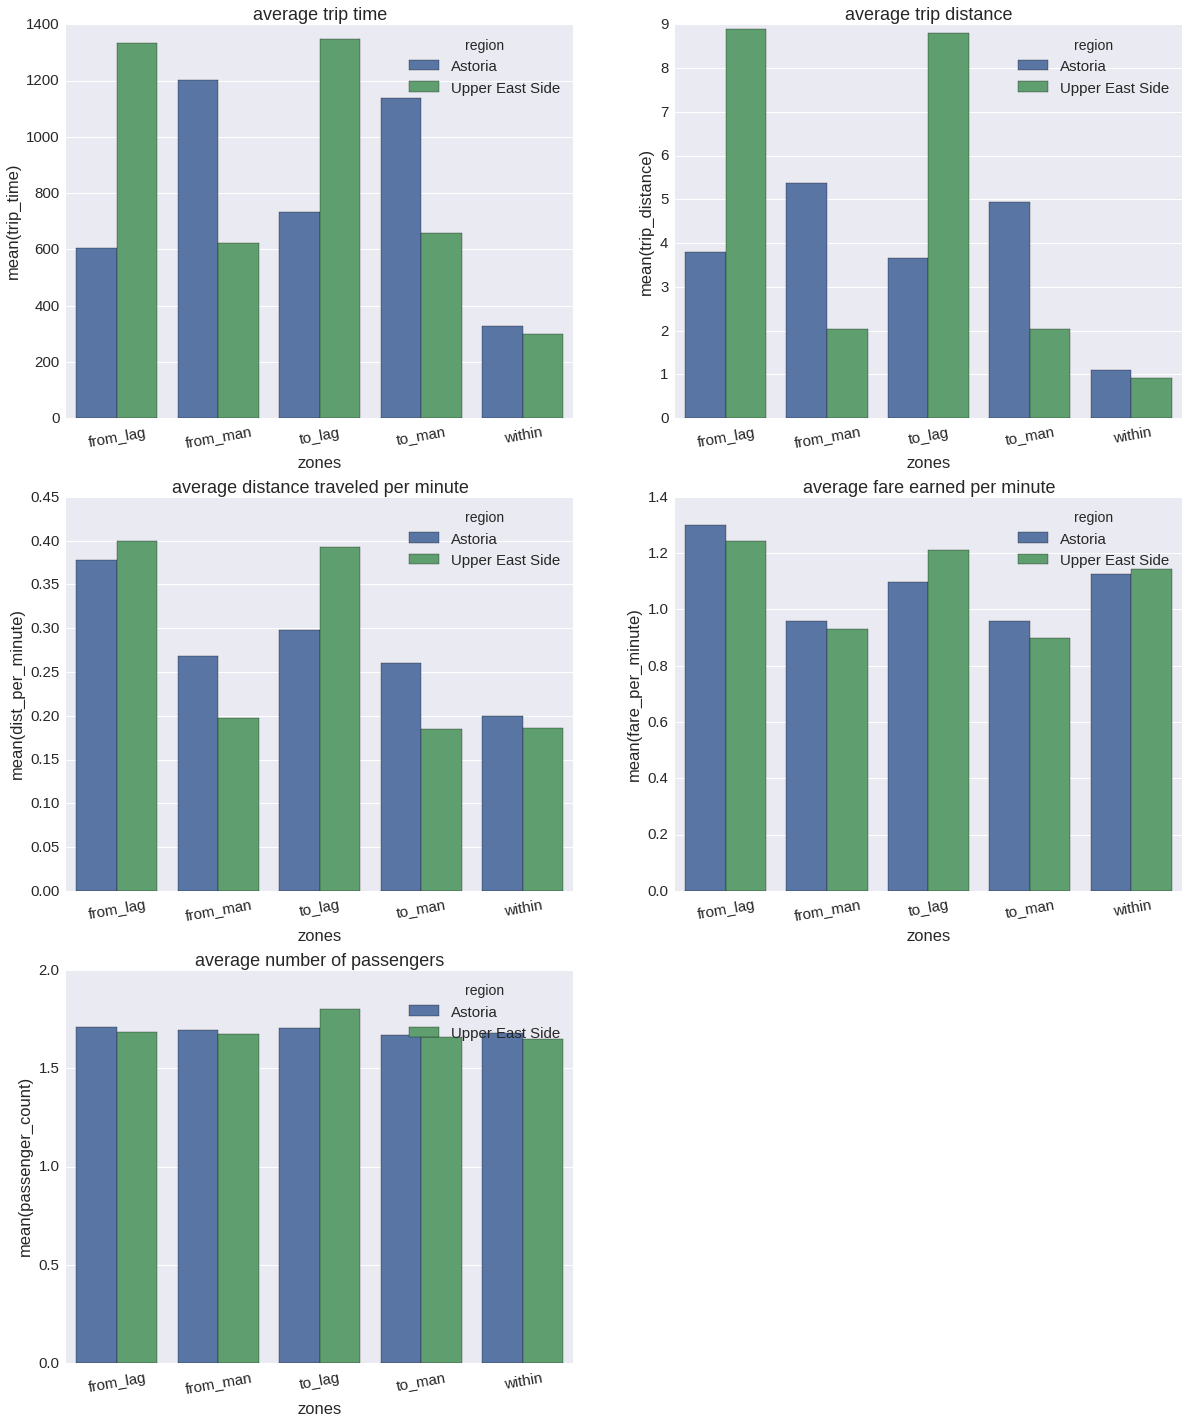

In [13]:
y_cols = ["trip_time", "trip_distance", "dist_per_minute", "fare_per_minute", "passenger_count"]
x_cols = ["zones"]*len(y_cols)
titles = ["average trip time", "average trip distance", "average distance traveled per minute",
          "average fare earned per minute", "average number of passengers"]

sns.set(font_scale=1.5)
plot_bar(agg_rides, x_cols, y_cols, titles)

### waiting time for drivers 

In [14]:
# query the rides information table for future use
# pickup_datetime, dropoff_datetime, pickup_LocationID, 
#                                dropoff_LocationID, medallion
query_taxi = '''SELECT DISTINCT medallion
                FROM trip_data'''
df_taxi = pd.read_sql_query(query_taxi, disk_engine)
medallions = df_taxi.medallion.tolist()

pickle.dump(medallions,open("medallions_all.txt","w"))

In [15]:
def query_taxi_wait(df, medallion, zones, threshold):
    
    # query all the rides with the medallion id
    query_rides = '''SELECT medallion, hack_license, pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE medallion = {medallion_id}'''
    f = {"medallion_id": '"'+medallion +'"'}
    df_rides = pd.read_sql_query(query_rides.format(**f), disk_engine)
    
    if DEBUG:
        print "Medallion : ", medallion, "Number of rides : ", len(df_rides)
        
    # sort all the rides according to pickup time and dropoff time
    df_rides = df_rides.sort_values(['pickup_datetime', 'dropoff_datetime'], ascending=[1, 1]) 
    df_rides = df_rides.reset_index(drop=True)
    
    # get the rides wait time and travelled distance for rides in the zones
    for index, row in df_rides.iterrows():
        if row.dropoff_LocationID in zones:
            try:
                next_ride = df_rides.iloc[index+1]
            except:
                next_ride = []
            if len(next_ride) > 0:
                wait_time = (pd.to_datetime(next_ride.pickup_datetime) -
                             pd.to_datetime(row["dropoff_datetime"])).total_seconds()/60.0

                if wait_time > 0 and wait_time < threshold:
                    row["wait_time"] = wait_time
                    row["delta_long"] = next_ride.pickup_long - row.dropoff_long
                    row["delta_lat"] = next_ride.pickup_lat - row.dropoff_lat
                    df.loc[df.shape[0]] = row   
    return df

In [24]:
cols = ["medallion", "hack_license", "pickup_datetime", "dropoff_datetime", "pickup_LocationID", "pickup_long",
        "pickup_lat","dropoff_LocationID", "dropoff_long", "dropoff_lat"]
df_wait = pd.DataFrame(columns = cols + ["wait_time", "delta_long", "delta_lat"])

for med in medallions[:10]:
    df_wait = query_taxi_wait(df_wait, med, Astoria_zones+Laguardia_zones+Upper_east_zones, 240.0)

Medallion :  3418135604CD3F357DD9577AF978C5C0 Number of rides :  534
Medallion :  6D3B2A7682C30DCF64F3F12976EF93B6 Number of rides :  1060
Medallion :  6D49E494913752B75B2685E0019FF3D5 Number of rides :  1009
Medallion :  4C4A0AFC432A1A87E97ED8F18403FF6E Number of rides :  761
Medallion :  1258CA1DF5E2A9E9A9F7848408A7AAEB Number of rides :  1298
Medallion :  3B0E8DC736D1E0D35C698D7B0BF9CBFA Number of rides :  695
Medallion :  1A575E39B0D761E6496F002F79E34D19 Number of rides :  1521
Medallion :  A30A0C08B1331EC905B012947F22081F Number of rides :  787
Medallion :  EF74C4639B1D4D28B88DBCF0694DC821 Number of rides :  1305
Medallion :  C647516A7B73EC8105E8DE5494B4CDB9 Number of rides :  1201


In [25]:
df_wait.describe()

,pickup_LocationID,pickup_long,pickup_lat,dropoff_LocationID,dropoff_long,dropoff_lat,wait_time,delta_long,delta_lat
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,175.294118,-73.968430,40.762210,203.260325,-73.941881,40.772663,25.544451,-0.008175,-0.005795
std,65.707523,0.027064,0.021156,63.598816,0.036243,0.006862,37.317649,0.033055,0.018893
min,4.000000,-74.014969,40.644573,7.000000,-73.972839,40.752853,0.366667,-0.137665,-0.133709
25%,140.000000,-73.983368,40.750974,179.000000,-73.964451,40.767554,4.283333,-0.011204,-0.010277
50%,164.000000,-73.971672,40.763809,236.000000,-73.958588,40.773090,11.716667,-0.001160,-0.001091
75%,236.000000,-73.958332,40.775791,237.000000,-73.930508,40.777966,28.108333,0.002571,0.001734
max,263.000000,-73.776634,40.815807,237.000000,-73.861259,40.787838,232.183333,0.165619,0.036221


In [26]:
df_wait["region"] = df_wait["dropoff_LocationID"].apply(region)

In [27]:
agg_wait = df_wait[["wait_time", "region"]].groupby("region").describe().reset_index()

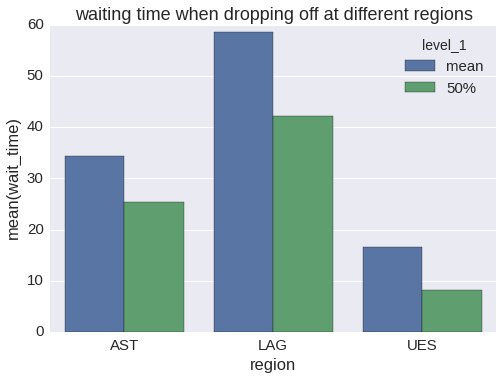

In [28]:
sns.set(font_scale=1.5)
sns.barplot(x='region',y='wait_time',data=agg_wait[agg_wait.level_1.isin(["mean", "50%"])], hue='level_1')
plt.title("waiting time when dropping off at different regions")

In [29]:
df_wait["dropoff_hour"] = df_wait["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).hour)
agg_wait_by_hour = df_wait[["wait_time", "region", "dropoff_hour"]] \
                    .groupby(["region", "dropoff_hour"]).describe().reset_index()

In [30]:
agg_wait_by_hour.head()

,region,dropoff_hour,level_2,wait_time
0,AST,0,count,6.000000
1,AST,0,mean,84.833333
2,AST,0,std,90.927580
3,AST,0,min,4.366667
4,AST,0,25%,17.612500


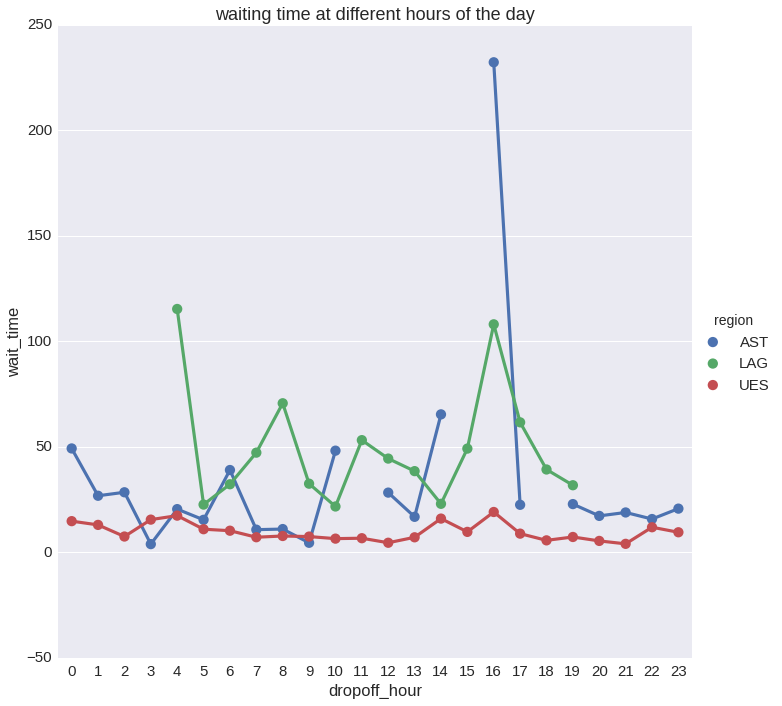

In [31]:
sns.set(font_scale=1.5)
sns.factorplot(x='dropoff_hour',y='wait_time',
               data=agg_wait_by_hour[agg_wait_by_hour.level_2=="50%"],
               hue='region', size=10)
plt.title("waiting time at different hours of the day")

**Question 3. Would you provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why? For reference, Via started as a commuter service between the Upper East Side and Midtown.**

### flow of traffic during different hours of the day

In [103]:
def query_flow(zones, is_in):
    if is_in:
        # query all the rides coming in to the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE dropoff_LocationID IN ({zone_ids})'''
    else:
        # query all the rides coming out of the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE pickup_LocationID IN ({zone_ids})'''
    f = {"zone_ids": ",".join([str(i) for i in zones])}
    return pd.read_sql_query(query_rides.format(**f), disk_engine)

In [111]:
df_flow_in = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones+Steinway_zones, is_in=True)
print "Number of rides: ", len(df_flow_in), "\n", df_flow_in.dtypes
df_flow_in.head()

Number of rides:  959502 
pickup_datetime        object
dropoff_datetime       object
pickup_LocationID     float64
pickup_long           float64
pickup_lat            float64
dropoff_LocationID    float64
dropoff_long          float64
dropoff_lat           float64
dtype: object


,pickup_datetime,dropoff_datetime,pickup_LocationID,pickup_long,pickup_lat,dropoff_LocationID,dropoff_long,dropoff_lat
0,2013-08-30 07:57:00,2013-08-30 08:30:00,132,-73.791359,40.645657,7,-73.922501,40.758766
1,2013-08-30 17:43:38,2013-08-30 17:47:16,236,-73.956604,40.777966,237,-73.966637,40.764137
2,2013-08-29 19:17:22,2013-08-29 19:24:35,43,-73.978256,40.766685,236,-73.959389,40.780392
3,2013-08-26 11:24:38,2013-08-26 11:29:58,162,-73.968887,40.758751,237,-73.961380,40.772644
4,2013-08-30 00:20:14,2013-08-30 00:30:42,236,-73.952995,40.783325,236,-73.953270,40.783489


In [112]:
df_flow_out = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones+Steinway_zones, is_in=False)
print "Number of rides: ", len(df_flow_out), "\n", df_flow_out.dtypes
df_flow_out.head()

Number of rides:  1044390 
pickup_datetime        object
dropoff_datetime       object
pickup_LocationID     float64
pickup_long           float64
pickup_lat            float64
dropoff_LocationID    float64
dropoff_long          float64
dropoff_lat           float64
dtype: object


,pickup_datetime,dropoff_datetime,pickup_LocationID,pickup_long,pickup_lat,dropoff_LocationID,dropoff_long,dropoff_lat
0,2013-08-30 23:26:23,2013-08-30 23:46:01,138,-73.862724,40.769062,163,-73.976845,40.764595
1,2013-08-27 11:37:45,2013-08-27 12:00:58,138,-73.872948,40.774212,170,-73.981438,40.743946
2,2013-08-28 19:53:06,2013-08-28 20:21:04,138,-73.873009,40.773956,114,-73.997437,40.730167
3,2013-08-28 07:07:32,2013-08-28 07:16:05,236,-73.952408,40.784161,162,-73.971863,40.754349
4,2013-08-30 17:43:38,2013-08-30 17:47:16,236,-73.956604,40.777966,237,-73.966637,40.764137


In [ ]:
df_flow_in["hour"] = df_flow_in["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_in["region"] = df_flow_in["pickup_LocationID"].apply(region)

agg_flow_in = df_flow_in[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_in.columns = ["region", "hour", "count_incoming"]
if DEBUG:
    print agg_flow_in.head()

In [ ]:
df_flow_out["hour"] = df_flow_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_out["region"] = df_flow_out["pickup_LocationID"].apply(region)

agg_flow_out = df_flow_out[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_out.columns = ["region", "hour", "count_outgoing"]
if DEBUG:
    print agg_flow_out.head()

ADD NEW ZONES

In [124]:
df_in = query_flow(Jackson_zones, is_in=True)
df_in["hour"] = df_in["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_in["region"] = df_in["pickup_LocationID"].apply(region)
df_flow_in = pd.concat([df_flow_in, df_in], axis=0)
print "Number of rides in: ", len(df_flow_in)

agg_flow_in = df_flow_in[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_in.columns = ["region", "hour", "count_incoming"]
if DEBUG:
    print agg_flow_in.head()

Number of rides in:  981017
  region  hour  count_incoming
0    AST     0            9450
1    AST     1            8781
2    AST     2            7038
3    AST     3            5315
4    AST     4            4625


In [125]:
df_out = query_flow(Jackson_zones, is_in=False)
df_out["hour"] = df_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_out["region"] = df_out["pickup_LocationID"].apply(region)
df_flow_out = pd.concat([df_flow_out, df_out], axis=0)
print "Number of rides in: ", len(df_flow_out)

agg_flow_out = df_flow_out[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_out.columns = ["region", "hour", "count_outgoing"]
if DEBUG:
    print agg_flow_in.head()

Number of rides in:  1050753
  region  hour  count_incoming
0    AST     0            9450
1    AST     1            8781
2    AST     2            7038
3    AST     3            5315
4    AST     4            4625


In [137]:
df_in = query_flow(Woodside_zones, is_in=True)
df_in["hour"] = df_in["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_in["region"] = df_in["pickup_LocationID"].apply(region)

df_flow_in = pd.concat([df_flow_in, df_in], axis=0)
print "Number of rides in: ", len(df_flow_in)

agg_flow_in = df_flow_in[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_in.columns = ["region", "hour", "count_incoming"]

Number of rides in:  997500


In [139]:
df_out = query_flow(Woodside_zones, is_in=False)
df_out["hour"] = df_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_out["region"] = df_out["pickup_LocationID"].apply(region)
df_flow_out = pd.concat([df_flow_out, df_out], axis=0)
print "Number of rides in: ", len(df_flow_out)

agg_flow_out = df_flow_out[['region', 'hour', 'pickup_datetime']].groupby(['region', 'hour'], as_index=False).count()
agg_flow_out.columns = ["region", "hour", "count_outgoing"]

Number of rides in:  1067575


In [156]:
agg_flow = pd.concat([agg_flow_in, agg_flow_out], axis=1, join='inner')
agg_flow = agg_flow.loc[:,~agg_flow.columns.duplicated()]
agg_flow["count_diff"] = agg_flow["count_incoming"] - agg_flow["count_outgoing"]
agg_flow.hour = agg_flow.hour.astype(int)

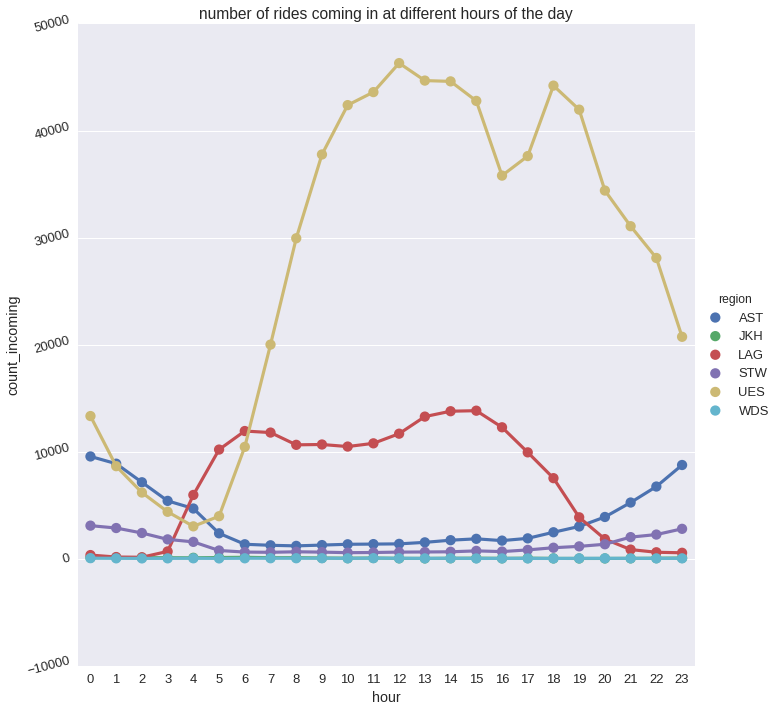

In [171]:
sns.set(font_scale=1.3)
sns.factorplot(x='hour',y='count_incoming',
               data=agg_flow,
               hue='region', size=10)
plt.yticks(rotation=15)
plt.title("number of rides coming in at different hours of the day")

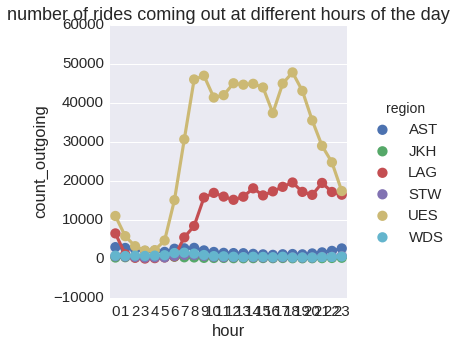

In [160]:
sns.set(font_scale=1.5)
sns.factorplot(x='hour',y='count_outgoing',
               data=agg_flow,
               hue='region', size=5)
plt.title("number of rides coming out at different hours of the day")

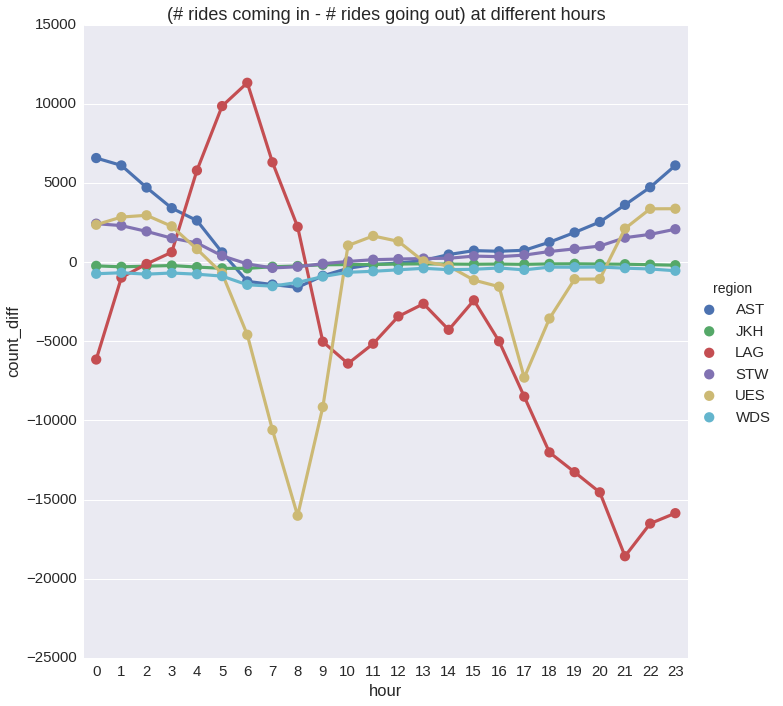

In [159]:
sns.set(font_scale=1.5)
sns.factorplot(x='hour',y='count_diff',
               data=agg_flow,
               hue='region', size=10)
plt.title("(# rides coming in - # rides going out) at different hours")

**Question 4. Would you launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?**

Statistical questions – answer these theoretically, no need to implement:
1. If you were given a metric for efficiency (assume you don't know how it's calculated), how would you determine whether a specific zone is more efficient than the rest of the city? How would you determine why it’s more efficient?
2. How would you compare the distributions of intra-city trip prices between two different cities? How would you test whether any differences you find are explained by distance and duration?
